In [351]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
torch.manual_seed(0)
torch.cuda.manual_seed(0)


In [352]:
torch.cuda.is_available()

True

In [353]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#--------------------------------
# Device configuration
#--------------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 32 * 32 * 3
hidden_size = [50]#, 35, 20, 15]
num_classes = 10
num_epochs = 10
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
train = True

Using device: cuda:0


In [354]:
device

device(type='cuda', index=0)

In [355]:
norm_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                          train=False,
                                          transform=norm_transform
                                          )

Files already downloaded and verified


In [356]:
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [363]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the mlp with the layer     #
        # configuration. input_size --> hidden_layers[0] --> hidden_layers[1] .... -->  #
        # hidden_layers[-1] --> num_classes                                             #
        # Make use of linear and relu layers from the torch.nn module                   #
        #################################################################################
        
        layers = [] #Use the layers list to store a variable number of layers
        
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
      
        
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        
        if len(hidden_layers) > 1:
            
            for i in range(1, len(hidden_layers)):
                
                layers.append(nn.ReLU())
              
                layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
    
          
        layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_layers[-1], num_classes))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Enter the layers into nn.Sequential, so the model may "see" them
        # Note the use of * in front of layers
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        # Note that you do not need to use the softmax operation at the end.            #
        # Softmax is only required for the loss computation and the criterion used below#
        # nn.CrossEntropyLoss() already integrates the softmax and the log loss together#
        #################################################################################
        
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        x = x.view(-1, 32 * 32 * 3)
        
        #for layer in self.layers:
            
            #x = layer(x)
        #x = self.l1(x)
        #x = self.relu(x)
        #out = self.l2(x)
        out = self.layers(x)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        return out

In [374]:
input_size = 32 * 32 * 3
hidden_size = [[50], [150,30] ,[150,50,30], [150,50,30,20]] #120, 40 -54,3 / 150,30 -54.7
num_classes = 20
num_epochs = 10
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000

In [375]:
train_score =[]
validation_score = []
test_score = []


for hidden in hidden_size:
    train = True 
    model = MultiLayerPerceptron(input_size, hidden, num_classes).to(device)
    fake_val = []
    fake_train = []
    print(f'Our model has this layers Sequential: {model}')
    print(' ')
    if train:
        model.apply(weights_init)
        model.train() #set dropout and batch normalization layers to training mode

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

        # Train the model
        lr = learning_rate
        total_step = len(train_loader)
        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                # Move tensors to the configured device
                images = images.to(device)
                labels = labels.to(device)
                #################################################################################
                # TODO: Implement the training code                                             #
                # 1. Pass the images to the model                                               #
                # 2. Compute the loss using the output and the labels.                          #
                # 3. Compute gradients and update the model using the optimizer                 #
                # Use examples in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
                #################################################################################
                # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                #for image in images:
                outputs = model(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

                if (i+1) % 100 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                for images, labels in train_loader:
                
                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels.shape[0]
                    n_correct += (predicted == labels).sum().item()

                train_acc = round(100 * (n_correct / n_samples), 1) 
                loss_t = loss.item()

                fake_train.append(train_acc)
                print(f'Train Accuracy: { train_acc} %')
            # Code to update the lr
            lr *= learning_rate_decay
            update_lr(optimizer, lr)
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    ####################################################
                    # TODO: Implement the evaluation code              #
                    # 1. Pass the images to the model                  #
                    # 2. Get the most confident predicted class        #
                    ####################################################
                    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                    
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    
        

                    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    fake_val.append(100 * correct / total)

                print('Validation accuracy is: {} % '.format(100 * correct / total))
                print(' ')

        ##################################################################################
        # TODO: Now that you can train a simple two-layer MLP using above code, you can  #
        # easily experiment with adding more layers and different layer configurations   #
        # and let the pytorch library handle computing the gradients                     #
        #                                                                                #
        # Experiment with different number of layers (at least from 2 to 5 layers) and   #
        # record the final validation accuracies Report your observations on how adding  #
        # more layers to the MLP affects its behavior. Try to improve the model          #
        # configuration using the validation performance as the guidance. You can        #
        # experiment with different activation layers available in torch.nn, adding      #
        # dropout layers, if you are interested. Use the best model on the validation    #
        # set, to evaluate the performance on the test set once and report it            #
        ##################################################################################

        # Save the model checkpoint
        torch.save(model.state_dict(), 'model.ckpt')
        
    else:
        # Run the test code once you have your by setting train flag to false
        # and loading the best model

        best_model = None
        best_model = torch.load('model.ckpt')
        
        model.load_state_dict(best_model)
        
        # Test the model
        model.eval() #set dropout and batch normalization layers to evaluation mode
        
        # In test phase, we don't need to compute gradients (for memory efficiency)
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                ####################################################
                # TODO: Implement the evaluation code              #
                # 1. Pass the images to the model                  #
                # 2. Get the most confident predicted class        #
                ####################################################
                # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                if total == 1000:
                    break

            print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

#############################################################################################################################
############### Start train Model ###########################################################################################
    train_score.append(max(fake_train))
    validation_score.append(max(fake_val))

    train = False 
    if train:
        model.apply(weights_init)
        model.train() #set dropout and batch normalization layers to training mode

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

        # Train the model
        lr = learning_rate
        total_step = len(train_loader)
        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                # Move tensors to the configured device
                images = images.to(device)
                labels = labels.to(device)
                #################################################################################
                # TODO: Implement the training code                                             #
                # 1. Pass the images to the model                                               #
                # 2. Compute the loss using the output and the labels.                          #
                # 3. Compute gradients and update the model using the optimizer                 #
                # Use examples in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
                #################################################################################
                # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                #for image in images:
                outputs = model(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

                if (i+1) % 100 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                for images, labels in train_loader:
                
                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels.shape[0]
                    n_correct += (predicted == labels).sum().item()


                acc_t = n_correct / n_samples
                loss_t = loss.item()
        
                print(f'Train Accuracy: {round(100 * acc_t, 1)} %')
            # Code to update the lr
            lr *= learning_rate_decay
            update_lr(optimizer, lr)
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    ####################################################
                    # TODO: Implement the evaluation code              #
                    # 1. Pass the images to the model                  #
                    # 2. Get the most confident predicted class        #
                    ####################################################
                    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                    
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    
        

                    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                print('Validation accuracy is: {} % '.format(100 * correct / total))
                print(' ')

        ##################################################################################
        # TODO: Now that you can train a simple two-layer MLP using above code, you can  #
        # easily experiment with adding more layers and different layer configurations   #
        # and let the pytorch library handle computing the gradients                     #
        #                                                                                #
        # Experiment with different number of layers (at least from 2 to 5 layers) and   #
        # record the final validation accuracies Report your observations on how adding  #
        # more layers to the MLP affects its behavior. Try to improve the model          #
        # configuration using the validation performance as the guidance. You can        #
        # experiment with different activation layers available in torch.nn, adding      #
        # dropout layers, if you are interested. Use the best model on the validation    #
        # set, to evaluate the performance on the test set once and report it            #
        ##################################################################################

        # Save the model checkpoint
        torch.save(model.state_dict(), 'model.ckpt')
        
    else:
        # Run the test code once you have your by setting train flag to false
        # and loading the best model

        best_model = None
        best_model = torch.load('model.ckpt')
        
        model.load_state_dict(best_model)
        
        # Test the model
        model.eval() #set dropout and batch normalization layers to evaluation mode
        
        # In test phase, we don't need to compute gradients (for memory efficiency)
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                ####################################################
                # TODO: Implement the evaluation code              #
                # 1. Pass the images to the model                  #
                # 2. Get the most confident predicted class        #
                ####################################################
                # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                if total == 1000:
                    break
            test_score.append(100 * correct / total)
            print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))
            print(' ')






Our model has this layers Sequential: MultiLayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
  )
)
 
Epoch [1/10], Step [100/245], Loss: 1.8140
Epoch [1/10], Step [200/245], Loss: 1.6253
Train Accuracy: 41.4 %
Validation accuracy is: 41.8 % 
 
Epoch [2/10], Step [100/245], Loss: 1.6391
Epoch [2/10], Step [200/245], Loss: 1.5100
Train Accuracy: 46.0 %
Validation accuracy is: 44.3 % 
 
Epoch [3/10], Step [100/245], Loss: 1.5584
Epoch [3/10], Step [200/245], Loss: 1.5331
Train Accuracy: 48.3 %
Validation accuracy is: 48.5 % 
 
Epoch [4/10], Step [100/245], Loss: 1.4467
Epoch [4/10], Step [200/245], Loss: 1.5114
Train Accuracy: 50.1 %
Validation accuracy is: 48.0 % 
 
Epoch [5/10], Step [100/245], Loss: 1.4655
Epoch [5/10], Step [200/245], Loss: 1.3899
Train Accuracy: 51.2 %
Validation accuracy is: 48.2 % 
 
Epoch [6/10], Step [100/245], Loss: 1.4968
Epoch [6/10]

In [396]:
x_hidden = [i+2 for i in range(len(hidden_size))]
print(train_score)
print(validation_score)
print(test_score)

[54.7, 59.0, 47.5, 39.8]
[51.5, 56.0, 47.833333333333336, 42.0]
[50.5, 53.3, 45.9, 37.5]


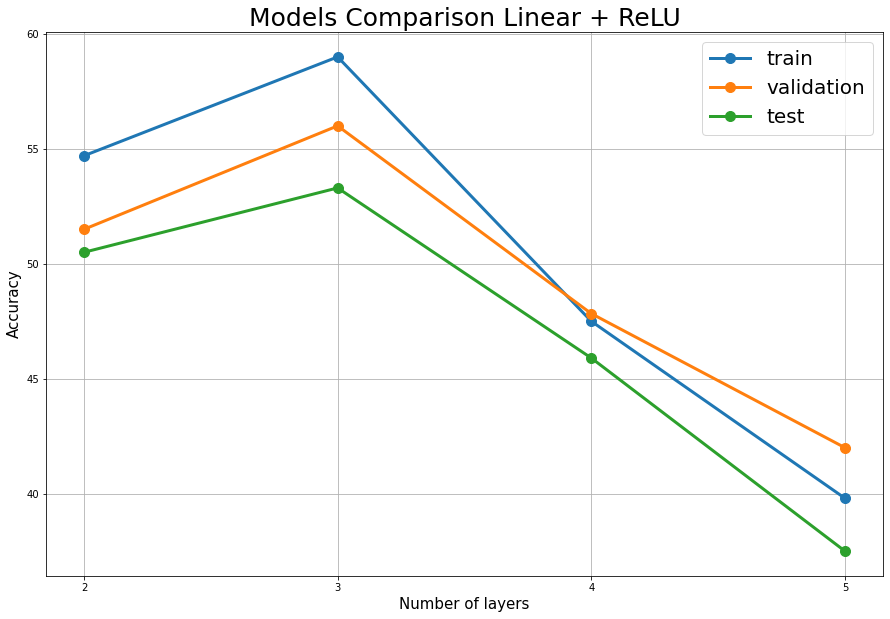

In [417]:
import matplotlib.pyplot as plt

plt.figure(figsize= (15, 10))
plt.title('Models Comparison Linear + ReLU', size = 25)
plt.xlabel('Number of layers', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.plot(x_hidden , train_score, label = 'train', marker = 'o', linewidth = 3, markersize = 10)
plt.plot(x_hidden, validation_score, label = 'validation', marker = 'o', linewidth = 3, markersize = 10)
plt.plot(x_hidden, test_score, label = 'test', marker = 'o', linewidth = 3, markersize = 10)
plt.xticks(x_hidden)
plt.grid()
plt.legend(fontsize = 20)
plt.savefig('plot_question4a')
